# Differential Gene Expression Analysis

## Introduction

In this notebook we shall examine an HCC RNA-seq gene expression dataset, attempting to explore the genes that are overexpressed or underexpressed. This dataset was originally used in a study published in 2021 by Han et al. which can be access [here](https://www.nature.com/articles/s41598-021-96952-x).

## Data Preparation

In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# PYDESEQ2
import os
import pickle as pkl
#import pydeseq2

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be saved
    OUTPUT_PATH = "../output_files/synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist
#

Let's start by importing and preparing our data.

In [2]:
# Import the RNA Seq data
dt = pd.read_csv('Datasets/cleaned_RNASeqHCC.csv', header=0, skipinitialspace = True)
print(dt.shape)
dt

(30474, 36)


,IDs,Symbol,C6,C7,C5,C61,C4,C19,C29,C2,...,L31,L39,L41,L42,L44,L46,L51,L56,L7,L9
0,ENSG00000000003,TSPAN6,8.0,3.0,10.0,11.0,19.0,9.0,5.0,8.0,...,3.0,19.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0
1,ENSG00000000419,DPM1,364.0,400.0,297.0,375.0,459.0,383.0,278.0,401.0,...,347.0,405.0,280.0,343.0,416.0,275.0,243.0,237.0,256.0,370.0
2,ENSG00000000457,SCYL3,528.0,716.0,499.0,370.0,546.0,497.0,400.0,456.0,...,514.0,615.0,381.0,423.0,490.0,361.0,515.0,165.0,481.0,277.0
3,ENSG00000000460,C1orf112,231.0,267.0,186.0,130.0,277.0,206.0,165.0,195.0,...,243.0,259.0,202.0,224.0,245.0,162.0,193.0,104.0,142.0,122.0
4,ENSG00000000938,FGR,4863.0,5386.0,5345.0,4854.0,5708.0,6281.0,4201.0,4901.0,...,6910.0,5345.0,5777.0,7030.0,5250.0,5196.0,6902.0,8727.0,4175.0,17309.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30469,NOVEL.995,NaN,0.0,4.0,2.0,5.0,8.0,6.0,1.0,1.0,...,8.0,3.0,4.0,11.0,9.0,8.0,11.0,0.0,8.0,1.0
30470,NOVEL.996,NaN,67.0,73.0,58.0,33.0,77.0,79.0,74.0,79.0,...,98.0,74.0,87.0,97.0,105.0,67.0,81.0,49.0,67.0,15.0
30471,NOVEL.997,NaN,3.0,19.0,10.0,5.0,11.0,16.0,8.0,2.0,...,12.0,3.0,3.0,8.0,6.0,7.0,3.0,2.0,5.0,2.0
30472,NOVEL.998,NaN,188.0,408.0,348.0,694.0,404.0,235.0,293.0,589.0,...,331.0,277.0,211.0,183.0,403.0,192.0,567.0,1769.0,392.0,1033.0


In [3]:
# Drop rows with no symbols (NaN)
dt = dt.dropna()
#print(df_rna.shape)
#df_rna

In [4]:
# Find the index of rows with the maximum values in the specified columns
max_indices = dt.groupby('Symbol')[dt.columns[2:36]].idxmax()

# Flatten the indices to get a list of indices to keep
indices_to_keep = max_indices.values.flatten()

# Keep rows with maximum values based on the indices
df_max_values = dt.loc[indices_to_keep]

# Drop duplicate rows based on column 'A' while keeping the first occurrence
df_rna = df_max_values.drop_duplicates(subset='Symbol', keep='first')

# Reset the index of the resulting DataFrame
df_rna = df_rna.reset_index(drop=True)
#df_rna

In [5]:
# Set column 'Symbol' as the index
df_rna = df_rna.set_index('Symbol')
#df_rna

In [6]:
# Drop column 'IDs' from the dataframe
df_rna = df_rna.drop(['IDs'], axis=1)
print(df_rna.shape)
df_rna

(26575, 34)


,C6,C7,C5,C61,C4,C19,C29,C2,C30,C32,...,L31,L39,L41,L42,L44,L46,L51,L56,L7,L9
Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,24.0,26.0,21.0,25.0,7.0,21.0,23.0,6.0,11.0,14.0,...,25.0,20.0,12.0,19.0,9.0,1.0,17.0,11.0,18.0,5.0
A1BG-AS1,46.0,66.0,46.0,49.0,38.0,41.0,46.0,39.0,45.0,43.0,...,32.0,33.0,35.0,29.0,59.0,14.0,40.0,17.0,41.0,15.0
A1CF,6.0,14.0,3.0,4.0,6.0,4.0,3.0,6.0,0.0,1.0,...,2.0,0.0,7.0,6.0,2.0,2.0,4.0,3.0,4.0,2.0
A2M,4718.0,10843.0,4560.0,5378.0,3530.0,6924.0,3117.0,2733.0,3640.0,4353.0,...,2356.0,4318.0,1364.0,3902.0,3584.0,6622.0,4312.0,576.0,5644.0,1738.0
A2M-AS1,869.0,2127.0,933.0,967.0,579.0,1202.0,540.0,526.0,805.0,813.0,...,466.0,794.0,261.0,706.0,664.0,1213.0,821.0,110.0,1203.0,359.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,10.0,10.0,10.0,10.0,13.0,5.0,12.0,2.0,8.0,14.0,...,6.0,14.0,14.0,7.0,17.0,5.0,8.0,2.0,35.0,4.0
ZYG11B,1083.0,1282.0,1088.0,899.0,1089.0,1082.0,952.0,1082.0,918.0,797.0,...,1049.0,1022.0,1088.0,1238.0,942.0,710.0,859.0,700.0,653.0,1200.0
ZYX,2224.0,1663.0,2113.0,3253.0,2630.0,2599.0,2346.0,2938.0,2739.0,2785.0,...,2209.0,3233.0,2271.0,2353.0,2225.0,2073.0,2194.0,4479.0,1985.0,6091.0


In [7]:
df = df_rna

In [8]:
# Let's tanspose the data so that we have a new data such that each row represents a sample and 
# each collumn will represents a specific gene.
X_sample = df.transpose()
print(X_sample.shape)
X_sample.head()

(34, 26575)


Symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C6,24.0,46.0,6.0,4718.0,869.0,7.0,698.0,11.0,299.0,227.0,...,148.0,40.0,220.0,498.0,1377.0,10.0,1083.0,2224.0,3497.0,1308.0
C7,26.0,66.0,14.0,10843.0,2127.0,6.0,1790.0,16.0,400.0,432.0,...,205.0,30.0,331.0,742.0,2075.0,10.0,1282.0,1663.0,5315.0,1566.0
C5,21.0,46.0,3.0,4560.0,933.0,8.0,697.0,11.0,257.0,265.0,...,135.0,39.0,256.0,489.0,1715.0,10.0,1088.0,2113.0,3923.0,1257.0
C61,25.0,49.0,4.0,5378.0,967.0,9.0,735.0,9.0,326.0,267.0,...,119.0,25.0,281.0,562.0,1596.0,10.0,899.0,3253.0,3974.0,1141.0
C4,7.0,38.0,6.0,3530.0,579.0,13.0,597.0,30.0,291.0,249.0,...,142.0,36.0,263.0,547.0,1525.0,13.0,1089.0,2630.0,4054.0,1458.0


In [9]:
# Create a design matrix that describes the experimental groups or conditions
sample_df = pd.DataFrame({'samplename': df.columns}) \
        .assign(sample = lambda d: d.samplename.str.extract('([CL])', expand=False)) \
        .assign(replicate = lambda d: d.groupby('sample').cumcount() + 1)
sample_df.index = sample_df.samplename
sample_df

,samplename,sample,replicate
samplename,,,
C6,C6,C,1
C7,C7,C,2
C5,C5,C,3
C61,C61,C,4
C4,C4,C,5
C19,C19,C,6
C29,C29,C,7
C2,C2,C,8
C30,C30,C,9


In [10]:
# Data
counts_df = X_sample
clinical_df = sample_df

In [11]:
counts_df

Symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C6,24.0,46.0,6.0,4718.0,869.0,7.0,698.0,11.0,299.0,227.0,...,148.0,40.0,220.0,498.0,1377.0,10.0,1083.0,2224.0,3497.0,1308.0
C7,26.0,66.0,14.0,10843.0,2127.0,6.0,1790.0,16.0,400.0,432.0,...,205.0,30.0,331.0,742.0,2075.0,10.0,1282.0,1663.0,5315.0,1566.0
C5,21.0,46.0,3.0,4560.0,933.0,8.0,697.0,11.0,257.0,265.0,...,135.0,39.0,256.0,489.0,1715.0,10.0,1088.0,2113.0,3923.0,1257.0
C61,25.0,49.0,4.0,5378.0,967.0,9.0,735.0,9.0,326.0,267.0,...,119.0,25.0,281.0,562.0,1596.0,10.0,899.0,3253.0,3974.0,1141.0
C4,7.0,38.0,6.0,3530.0,579.0,13.0,597.0,30.0,291.0,249.0,...,142.0,36.0,263.0,547.0,1525.0,13.0,1089.0,2630.0,4054.0,1458.0
C19,21.0,41.0,4.0,6924.0,1202.0,6.0,1170.0,12.0,252.0,347.0,...,148.0,22.0,178.0,437.0,1468.0,5.0,1082.0,2599.0,4171.0,1382.0
C29,23.0,46.0,3.0,3117.0,540.0,3.0,402.0,15.0,271.0,278.0,...,97.0,20.0,237.0,407.0,1444.0,12.0,952.0,2346.0,3708.0,1143.0
C2,6.0,39.0,6.0,2733.0,526.0,9.0,355.0,10.0,288.0,263.0,...,143.0,23.0,312.0,652.0,1540.0,2.0,1082.0,2938.0,4007.0,1259.0
C30,11.0,45.0,0.0,3640.0,805.0,2.0,508.0,11.0,282.0,276.0,...,119.0,26.0,223.0,433.0,1653.0,8.0,918.0,2739.0,4381.0,1106.0
C32,14.0,43.0,1.0,4353.0,813.0,6.0,678.0,20.0,230.0,182.0,...,105.0,25.0,199.0,404.0,1222.0,14.0,797.0,2785.0,3513.0,1072.0


In [12]:
clinical_df

,samplename,sample,replicate
samplename,,,
C6,C6,C,1
C7,C7,C,2
C5,C5,C,3
C61,C61,C,4
C4,C4,C,5
C19,C19,C,6
C29,C29,C,7
C2,C2,C,8
C30,C30,C,9


In [13]:
metadata = clinical_df.drop(['samplename'], axis=1)
metadata

,sample,replicate
samplename,,
C6,C,1
C7,C,2
C5,C,3
C61,C,4
C4,C,5
C19,C,6
C29,C,7
C2,C,8
C30,C,9


In [14]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="sample",
    refit_cooks=True,
    inference=inference,
)

In [15]:
# Fit dispersions and LFCs, and print dds
dds.deseq2()
print(dds)

Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 64.60 seconds.

Fitting dispersion trend curve...
... done in 1.96 seconds.

Fitting MAP dispersions...
... done in 68.07 seconds.

Fitting LFCs...
... done in 6.20 seconds.

Refitting 182 outliers.

Fitting dispersions...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 0.44 seconds.

Fitting LFCs...


AnnData object with n_obs × n_vars = 34 × 26575
    obs: 'sample', 'replicate'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'


... done in 0.28 seconds.



In [16]:
# Access dispersions and LFCs
print(dds.varm["LFC"])

          intercept  sample_L_vs_C
Symbol                            
A1BG       2.679586      -0.054998
A1BG-AS1   3.600991      -0.058156
A1CF       1.309777      -0.439934
A2M        8.545127      -0.502161
A2M-AS1    6.877647      -0.452747
...             ...            ...
ZYG11A     2.025696       0.167086
ZYG11B     6.837936       0.054865
ZYX        7.699890       0.501682
ZZEF1      8.229583       0.037550
ZZZ3       7.055658      -0.134311

[26575 rows x 2 columns]


In [17]:
# Statistical result/analysis
stat_res = DeseqStats(dds, inference=inference)

# Result summary
stat_res.summary()

#if SAVE:
#    with open(os.path.join(OUTPUT_PATH, "stat_results.pkl"), "wb") as f:
#        pkl.dump(stat_res, f)
# The results are then stored in the ``results_df`` attribute (``stat_res.results_df``).

Running Wald tests...
... done in 3.56 seconds.



Log2 fold change & Wald test p-value: sample L vs C
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Symbol                                                                       
A1BG        14.117519       -0.079346  0.227530 -0.348726  0.727295  0.834835
A1BG-AS1    35.509747       -0.083901  0.154698 -0.542352  0.587576  0.732020
A1CF         3.019975       -0.634690  0.424110 -1.496524  0.134517  0.273474
A2M       4126.734863       -0.724465  0.260873 -2.777084  0.005485  0.024312
A2M-AS1    793.674072       -0.653176  0.248910 -2.624147  0.008687  0.034874
...               ...             ...       ...       ...       ...       ...
ZYG11A       8.260677        0.241054  0.318876  0.755950  0.449679  0.618048
ZYG11B     958.937500        0.079153  0.065044  1.216924  0.223633  0.391486
ZYX       2927.502441        0.723774  0.205411  3.523535  0.000426  0.003258
ZZEF1     3821.998047        0.054174  0.053907  1.004945  0.314923  0.492622
ZZZ3      10

In [18]:
# Convert the result into a Pandas dataframe
res_df = stat_res.results_df
res_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Symbol,,,,,,
A1BG,14.117519,-0.079346,0.227530,-0.348726,0.727295,0.834835
A1BG-AS1,35.509747,-0.083901,0.154698,-0.542352,0.587576,0.732020
A1CF,3.019975,-0.634690,0.424110,-1.496524,0.134517,0.273474
A2M,4126.734863,-0.724465,0.260873,-2.777084,0.005485,0.024312
A2M-AS1,793.674072,-0.653176,0.248910,-2.624147,0.008687,0.034874
...,...,...,...,...,...,...
ZYG11A,8.260677,0.241054,0.318876,0.755950,0.449679,0.618048
ZYG11B,958.937500,0.079153,0.065044,1.216924,0.223633,0.391486
ZYX,2927.502441,0.723774,0.205411,3.523535,0.000426,0.003258


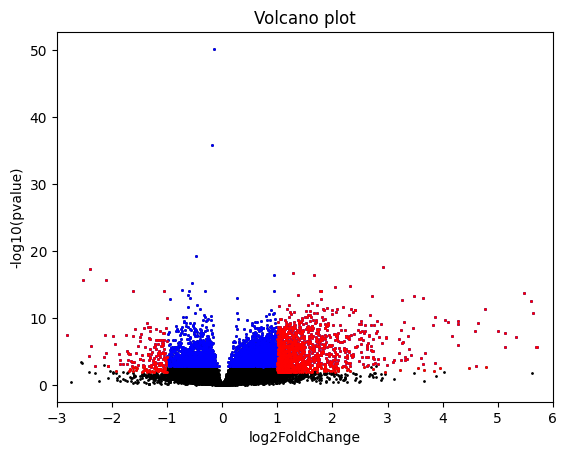

In [19]:
# Display volcano plot
plt.clf()

# Make a basic volcano plot
plt.scatter(res_df['log2FoldChange'], -np.log10(res_df['pvalue']), marker='o', color='black', s=1)
plt.title("Volcano plot")
plt.xlabel("log2FoldChange")
plt.ylabel("-log10(pvalue)")
plt.xlim(-3,6)

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
plt.scatter(res_df.loc[res_df['padj']<0.01, 'log2FoldChange'], -np.log10(res_df.loc[res_df['padj']<0.01, 'pvalue']), marker='o', color='blue', s=1)
plt.scatter(res_df.loc[(res_df['padj']<0.05) & (np.abs(res_df['log2FoldChange'])>=1), 'log2FoldChange'], -np.log10(res_df.loc[(res_df['padj']<0.05) & (np.abs(res_df['log2FoldChange'])>=1), 'pvalue']), marker='o', color='red', s=1)

plt.show()

In [20]:
# Get significant genes
significant_genes = res_df[(res_df.padj < 0.05) & (abs(res_df.log2FoldChange) >= 1)]
significant_genes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Symbol,,,,,,
ABCA1,1039.246216,1.439098,0.221850,6.486821,8.766655e-11,2.404740e-08
ABCA13,488.211395,1.856134,0.592851,3.130862,1.742938e-03,9.845918e-03
ABCA3P1,2.123036,1.716567,0.520972,3.294928,9.844686e-04,6.270904e-03
ABCC13,15.092897,5.703337,1.209148,4.716823,2.395560e-06,5.834196e-05
ABCC3,917.069946,1.264820,0.262903,4.810976,1.501951e-06,4.124271e-05
...,...,...,...,...,...,...
ZFPM2,13.256426,1.583292,0.361988,4.373883,1.220556e-05,2.056326e-04
ZNF185,1435.473633,1.381514,0.242071,5.707055,1.149474e-08,9.449253e-07
ZNF516-DT,11.978716,1.002212,0.292669,3.424388,6.161862e-04,4.342130e-03


In [21]:
# Save the dataframe of the DESEqresults to a file:
res_df.to_csv("Datasets/Result_DESeq_Analysis_RNASeqHCC_PRNA739257.csv", index=True)